# Exploratory Data Analysis (EDA)

In this notebook, we perform the **Exploratory Data Analysis (EDA)** to better understand the dataset and its underlying processes.  

EDA does not follow a single “correct” path. Instead, it is an iterative process where insights may lead us to revisit and refine specific steps later. At this stage, our goal is to explore the data, identify patterns, detect potential issues, and generate hypotheses that will guide feature engineering and model development.

---


## Import libraries and set preferences

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import mplcyberpunk
import matplotlib.pyplot as plt

In [2]:
# Numeric data format
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.options.display.float_format = '{:,.2f}'.format

# Graph's theme
plt.style.use("cyberpunk")
plt.style.use("dark_background")
plt.rcParams["axes.grid"] = False

---

## Load files

We start with a quick inspection of the files to check the available columns and the type of information included.  

Although Kaggle provides a dataset description, reviewing the files directly ensures accuracy and avoids relying on potentially outdated or incomplete documentation.

In [3]:
! head -n 2 ../data/PdM_errors.csv
! echo "---"
! head -n 2 ../data/PdM_failures.csv
! echo "---"
! head -n 2 ../data/PdM_machines.csv
! echo "---"
! head -n 2 ../data/PdM_maint.csv
! echo "---"
! head -n 2 ../data/PdM_telemetry.csv

"datetime","machineID","errorID"
2015-01-03 07:00:00,1,"error1"
---
"datetime","machineID","failure"
2015-01-05 06:00:00,1,"comp4"
---
"machineID","model","age"
1,"model3",18
---
"datetime","machineID","comp"
2014-06-01 06:00:00,1,"comp2"
---
"datetime","machineID","volt","rotate","pressure","vibration"
2015-01-01 06:00:00,1,176.217853015625,418.504078221616,113.077935462083,45.0876857639276


In [5]:
errors = pd.read_csv("../data/PdM_errors.csv", parse_dates=['datetime'])
failures = pd.read_csv("../data/PdM_failures.csv", parse_dates=['datetime'])
machines = pd.read_csv("../data/PdM_machines.csv")
maintenance = pd.read_csv("../data/PdM_maint.csv", parse_dates=['datetime'])
telemetry = pd.read_csv("../data/PdM_telemetry.csv", parse_dates=['datetime'])


---

## File-by-File EDA

We will begin the EDA on a file-by-file basis. Understanding each dataset individually helps ensure a smoother merging process later, as we will be aware of schema details, inconsistencies, and potential integration issues in advance.

### Telemetry file

We start the EDA with the **telemetry file**. Following a star-schema perspective, telemetry can be considered the **fact table**, as it records time-series data about machine behavior.  

In contrast, the other files play the role of **dimension tables** (providing contextual information such as maintenance or error codes) or even the **target variable** (failures).  


#### Author's description

* Telemetry Time Series Data (PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.

#### Quick Overview
* First a quick overview, dataframe shape, nulls, update frequency, etc.

In [6]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.22,418.50,113.08,45.09
1,2015-01-01 07:00:00,1,162.88,402.75,95.46,43.41
2,2015-01-01 08:00:00,1,170.99,527.35,75.24,34.18
3,2015-01-01 09:00:00,1,162.46,346.15,109.25,41.12
4,2015-01-01 10:00:00,1,157.61,435.38,111.89,25.99


In [7]:
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

In [8]:
telemetry.shape

(876100, 6)

In [9]:
telemetry.datetime.min(),telemetry.datetime.max()

(Timestamp('2015-01-01 06:00:00'), Timestamp('2016-01-01 06:00:00'))

In [10]:
telemetry.duplicated().sum()

np.int64(0)

In [11]:
telemetry.isnull().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64

In [12]:
telemetry.describe()

,datetime,machineID,volt,rotate,pressure,vibration
count,876100,"876,100.00","876,100.00","876,100.00","876,100.00","876,100.00"
mean,2015-07-02 18:00:00,50.50,170.78,446.61,100.86,40.39
min,2015-01-01 06:00:00,1.00,97.33,138.43,51.24,14.88
25%,2015-04-02 12:00:00,25.75,160.30,412.31,93.50,36.78
50%,2015-07-02 18:00:00,50.50,170.61,447.56,100.43,40.24
75%,2015-10-02 00:00:00,75.25,181.00,482.18,107.56,43.78
max,2016-01-01 06:00:00,100.00,255.12,695.02,185.95,76.79
std,NaN,28.87,15.51,52.67,11.05,5.37


**Preliminary Note:** From the initial exploration, we observe that the numerical variables (`volt`, `rotate`, `pressure`, `vibration`) fall within similar ranges and do not show significant differences in magnitude. This suggests that scaling techniques may not be necessary, although this assumption should be confirmed later depending on the models applied.

#### Data Quality
* Now, well check data consistency and completness.

In [13]:
telemetry.machineID.nunique()

100

In [14]:
telemetry.machineID.value_counts().value_counts()

count
8761    100
Name: count, dtype: int64

In [15]:
telemetry.machineID.value_counts().mean(), telemetry.machineID.value_counts().std()

(np.float64(8761.0), 0.0)

In [16]:
# Check the update frequency (or ime delta between records)
df = telemetry.sort_values(["machineID", "datetime"])
df["delta"] = df.groupby("machineID")["datetime"].diff()
df.groupby("machineID")["delta"].value_counts(normalize=True).head()

machineID  delta          
1          0 days 01:00:00   1.00
2          0 days 01:00:00   1.00
3          0 days 01:00:00   1.00
4          0 days 01:00:00   1.00
5          0 days 01:00:00   1.00
Name: proportion, dtype: float64

The telemetry file contains **876,100 records**, which aligns with the expected volume given:  
- 100 machines  
- 1 full year (2015, including the first record of 2016)  
- Hourly sampling (24 records per day per machine)

Also, the update frequency is consistent, as it includes a record for every machine, every hour and there's no missing information

#### Correlation Test
* Next, we'll run a brief correlation test of the numeric features

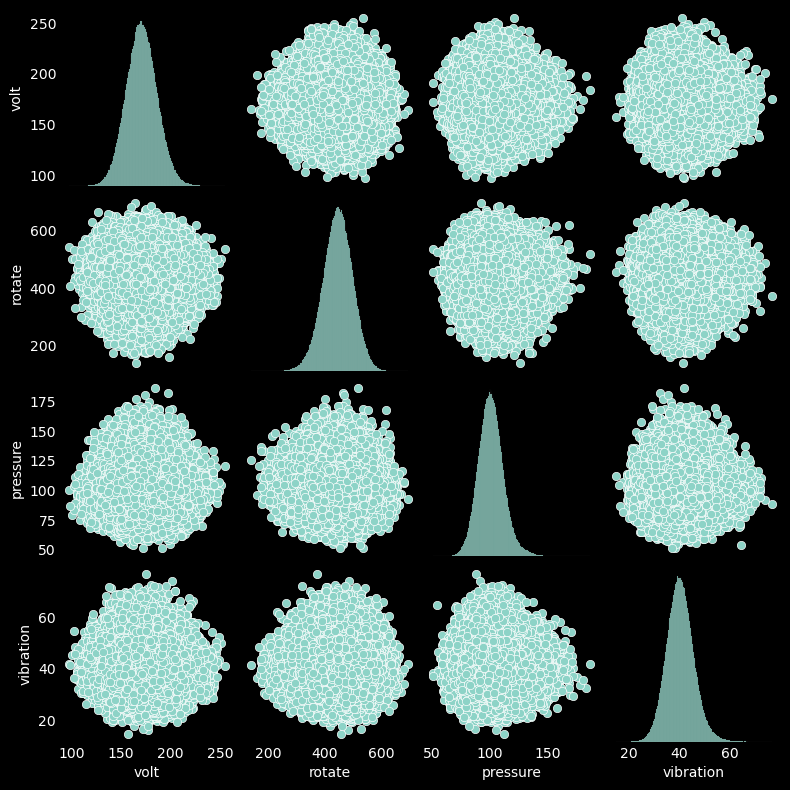

In [17]:
# Check possible correlations between numeric features
numeric = ['volt', 'rotate', 'pressure', 'vibration']
sns.pairplot(telemetry, vars=numeric, height=2)

#### Seasonality Check
* Next, we'll check for seasonality from a global perspective.

/home/maxkaizo/miniconda3/envs/walmart/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


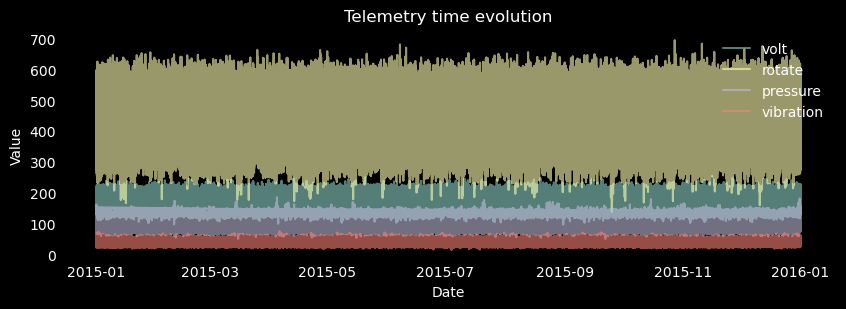

In [18]:
plt.figure(figsize=(10,3))

# use every column as a series
for col in ["volt", "rotate", "pressure", "vibration"]:
    plt.plot(telemetry["datetime"], telemetry[col], label=col, alpha=0.6)

plt.title("Telemetry time evolution")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

This plot shows the raw telemetry signals (`volt`, `rotate`, `pressure`, `vibration`) aggregated across all machines. At each timestamp, values from every machine are included, providing a global view of variable evolution over time.

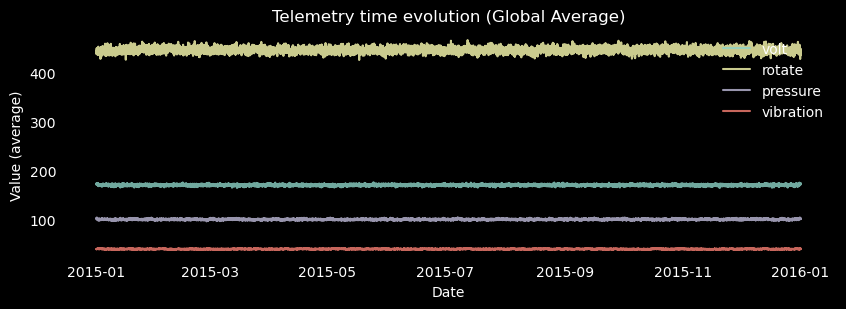

In [19]:
# Global average per hour (all machines)
hourly_global = telemetry.drop(columns=["machineID"]).groupby("datetime").mean()

plt.figure(figsize=(10,3))
for col in ["volt", "rotate", "pressure", "vibration"]:
    plt.plot(hourly_global.index, hourly_global[col], label=col, alpha=0.8)

plt.title("Telemetry time evolution (Global Average)")
plt.xlabel("Date")
plt.ylabel("Value (average)")
plt.legend()
plt.show()

Now, this plot shows the hourly averages of the telemetry variables (`volt`, `rotate`, `pressure`, `vibration`) across all machines. This reduces variability and shows a smoother global trend, with 24 aggregated records per day.


**Preliminary Note:** The temporal analysis of telemetry shows stable signals, with no evident trends or seasonality. This suggests that, in this dataset alone, generating lags or rolling averages may not be necessary as part of feature engineering. However, this conclusion may change once telemetry is integrated with the other datasets (failures, maintenance, replacements), where patterns preceding events could emerge.



#### Variation Check
* It seems that there's not much variation in the telemetry values, so we'll confirm it by calculating a variation coeficient

The **coefficient of variation (CV)** is a statistical measure of the relative variability of data. It's the ratio of the standard deviation to the mean, expressed as a percentage. A lower CV indicates less spread in the data relative to the mean, while a higher CV indicates more spread.

In [20]:
# Calculate descriptive stats for every machine
machine_summary = telemetry.groupby("machineID")[["volt","rotate","pressure","vibration"]].agg(["mean","std"])


# Calculate the coefficient of variation (CV) for each machine and each variable
cv = machine_summary.xs("std", axis=1, level=1) / machine_summary.xs("mean", axis=1, level=1)

# Coefficient of variation summary
cv.describe()


,volt,rotate,pressure,vibration
count,100.00,100.00,100.00,100.00
mean,0.09,0.12,0.11,0.13
std,0.00,0.00,0.00,0.00
min,0.09,0.11,0.10,0.13
25%,0.09,0.12,0.11,0.13
50%,0.09,0.12,0.11,0.13
75%,0.09,0.12,0.11,0.14
max,0.09,0.12,0.12,0.14


The coefficient of variation (CV) across machines is consistently low (≈0.09–0.14) for all telemetry variables.  
This confirms that signals are stable, with limited relative variability across machines.


#### **Preliminary EDA Summary (Telemetry):**  
- The dataset contains **8,761 records per machine** (100 machines in total), with no missing values.  
- Numerical variables (`volt`, `rotate`, `pressure`, `vibration`) show approximately normal distributions within bounded ranges.  
- No clear outliers or significant differences in scale are observed across variables.  
- Variables do not exhibit strong correlations with each other, suggesting relative independence of the measurements.  
- No seasonality or long-term trends are observed in the telemetry signals.  
- The coefficient of variation (CV) is consistently low across machines for all four variables, confirming limited relative variability.  
- At this stage, feature scaling does not appear necessary, although this assumption will be revisited depending on the modeling approach.

---

### Maintenance File

#### Author's description

* Maintenance (PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

#### Quick Overview
* First a quick overview, dataframe shape, nulls, update frequency, etc.

In [21]:
maintenance.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [22]:
maintenance.dtypes

datetime     datetime64[ns]
machineID             int64
comp                 object
dtype: object

In [23]:
maintenance.shape

(3286, 3)

In [24]:
maintenance.isnull().sum()

datetime     0
machineID    0
comp         0
dtype: int64

In [25]:
maintenance.duplicated().sum()

np.int64(0)

In [26]:
maintenance.machineID.nunique()

100

In [27]:
maintenance.machineID.value_counts().mean()

np.float64(32.86)

In [28]:
maintenance.datetime.min(),maintenance.datetime.max()

(Timestamp('2014-06-01 06:00:00'), Timestamp('2016-01-01 06:00:00'))

The data shows no inconsistencies; however, it represents an activity log, therefore, we cannot determine or confirm its completeness.  

It also includes records from 2014, but since the telemetry file only covers 2015, this additional information does not provide much value for our analysis.


#### Global Trends
* Identify potential trends.

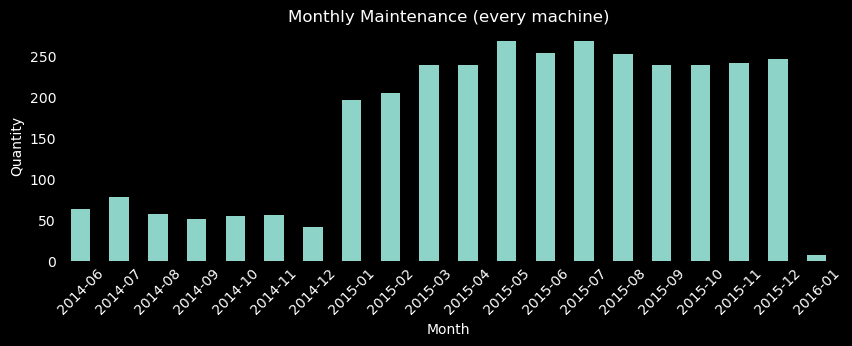

In [29]:
maintenance_monthly = maintenance.groupby(maintenance.datetime.dt.to_period("M")).size()

maintenance_monthly.plot(kind="bar", figsize=(10,3))
plt.title("Monthly Maintenance (every machine)")
plt.ylabel("Quantity")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.show()


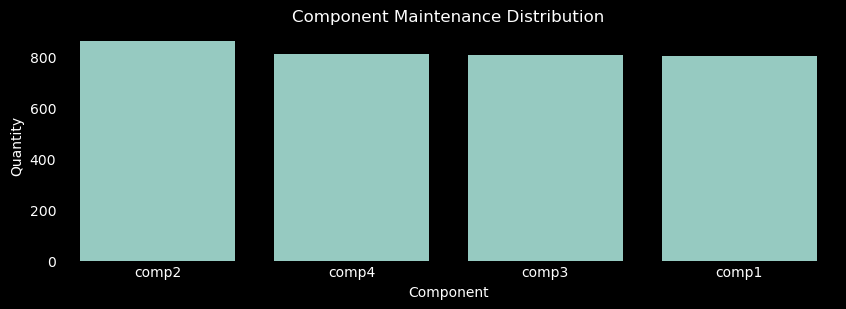

In [30]:
plt.figure(figsize=(10,3))
sns.countplot(data=maintenance, x="comp", order=maintenance["comp"].value_counts().index)
plt.title("Component Maintenance Distribution")
plt.ylabel("Quantity")
plt.xlabel("Component")
plt.show()


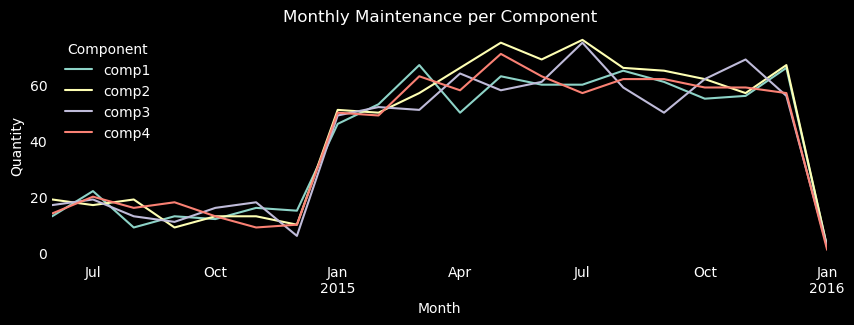

In [31]:
maintenance_comp_monthly = (
    maintenance.groupby([maintenance.datetime.dt.to_period("M"), "comp"])
    .size()
    .unstack(fill_value=0)
)

maintenance_comp_monthly.plot(figsize=(10,3))
plt.title("Monthly Maintenance per Component")
plt.ylabel("Quantity")
plt.xlabel("Month")
plt.legend(title="Component")
plt.show()


**Preliminary Note:** The monthly evolution by component shows an abrupt increase in maintenance activities starting in January 2015, consistent across all components. This shift likely reflects the adoption of a more aggressive preventive maintenance policy.  

Since the telemetry file only covers 2015, the 2014 records add little value to our analysis. It will be important to validate whether the increase in maintenance correlates with a reduction in failures, as this would confirm a relevant business change for the analysis.


#### Domain Reference  
To provide context, we will highlight trends and nuances that are common in maintenance scenarios.  
Examples include:  
* Frequency of maintenance over time  
* Maintenance distribution per machine  
* Maintenance distribution per component  


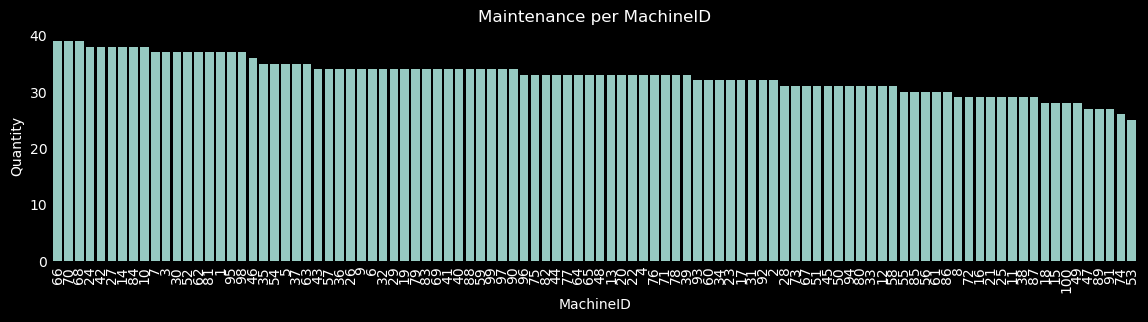

In [32]:
plt.figure(figsize=(14,3))
sns.countplot(data=maintenance, x="machineID", order=maintenance["machineID"].value_counts().index)
plt.title("Maintenance per MachineID")
plt.ylabel("Quantity")
plt.xlabel("MachineID")
plt.xticks(rotation=90)
plt.show()

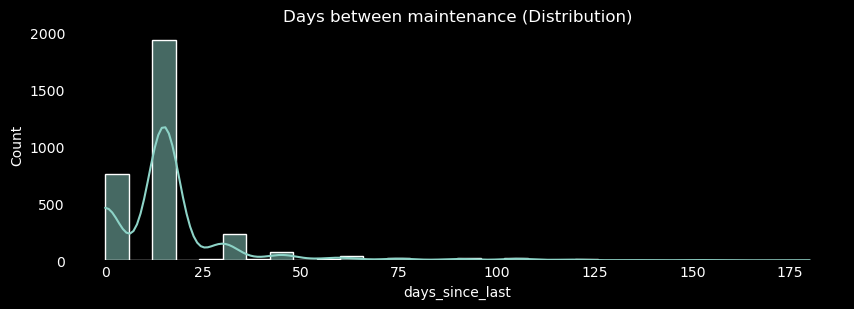

In [33]:
maintenance_sorted = maintenance.sort_values(["machineID","datetime"])
maintenance_sorted["days_since_last"] = maintenance_sorted.groupby("machineID")["datetime"].diff().dt.days
plt.figure(figsize=(10, 3))
sns.histplot(maintenance_sorted["days_since_last"].dropna(), bins=30, kde=True)
plt.title("Days between maintenance (Distribution)")
plt.show()


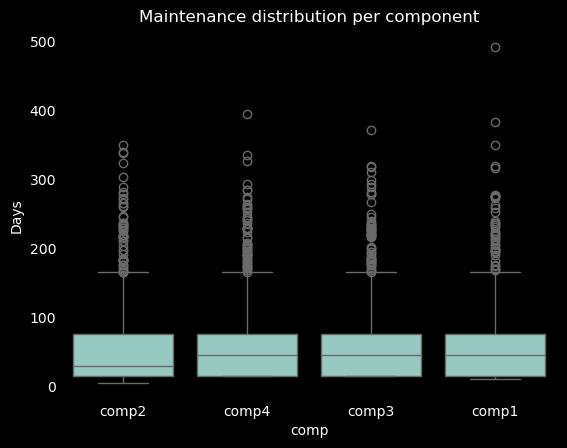

In [34]:
comp_interval = (
    maintenance_sorted.groupby(["machineID","comp"])["datetime"]
    .diff().dt.days
)
sns.boxplot(x=maintenance_sorted["comp"], y=comp_interval)
plt.title("Maintenance distribution per component")
plt.ylabel("Days")
plt.show()


#### **Preliminary Note (Maintenance):**  

- The maintenance file acts as a categorical event log. In the exploratory analysis, we reviewed frequencies and periodicity, but did not evaluate correlations or distributions since the variables are not continuous. The most relevant insights will emerge once this table is merged with `failures`, allowing us to distinguish between preventive and corrective maintenance.  

- The interval analysis (days between maintenance events) is particularly interesting from a feature engineering perspective, as it could provide strong predictive signals. In this synthetic dataset, distributions appear artificial and are unlikely to have major impact. However, in real-world data, such features (e.g., days since last maintenance) could play a critical role in model performance.


### Machines File (Inventory)

#### Author's description

* Metadata of Machines (PdM_Machines.csv): Model type & age of the Machines.

#### Quick Overview
* First a quick overview, dataframe shape, nulls, update frequency, etc.

In [35]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [36]:
machines.describe()

,machineID,age
count,100.00,100.00
mean,50.50,11.33
std,29.01,5.86
min,1.00,0.00
25%,25.75,6.75
50%,50.50,12.00
75%,75.25,16.00
max,100.00,20.00


In [37]:
machines.shape

(100, 3)

In [38]:
machines.isnull().sum()

machineID    0
model        0
age          0
dtype: int64

In [39]:
machines.model.value_counts()

model
model3    35
model4    32
model2    17
model1    16
Name: count, dtype: int64

The inventory is complete, it covers model and age

#### Distribution check

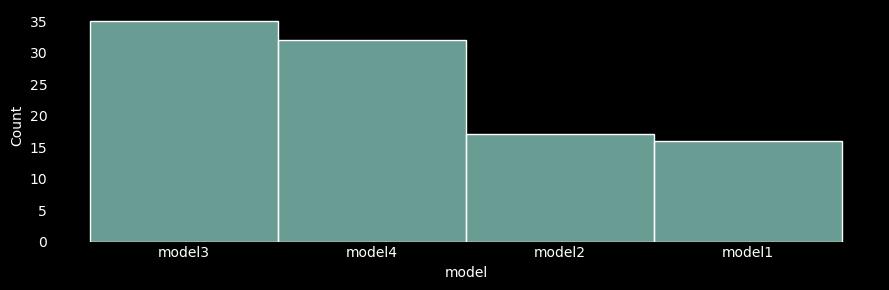

In [40]:
sns.displot(machines["model"], height=3, aspect=3)

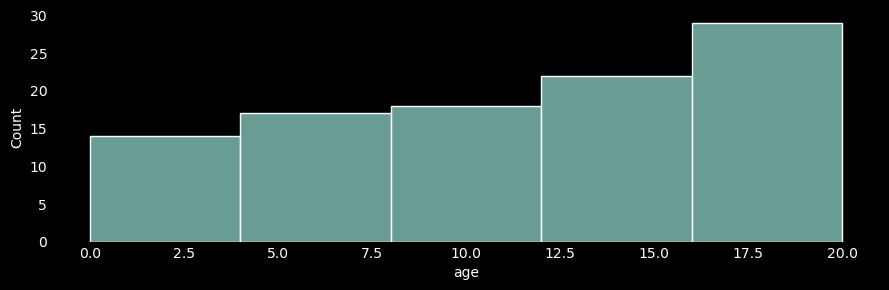

In [41]:
sns.displot(machines['age'], bins=5, height=3, aspect=3)

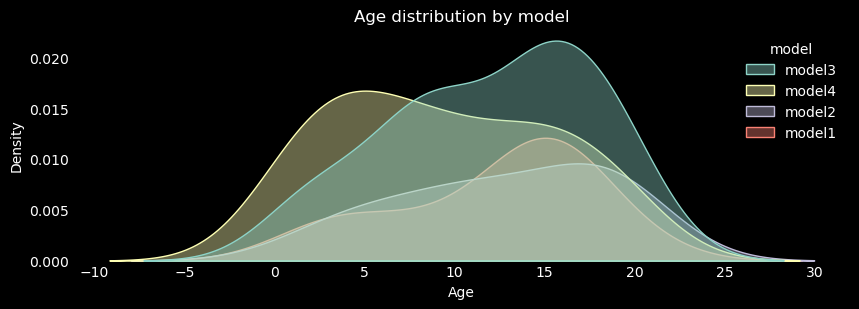

In [42]:
plt.figure(figsize=(10,3))
sns.kdeplot(data=machines, x="age", hue="model", fill=True, alpha=0.4)
plt.title("Age distribution by model")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()


#### **Preliminary EDA Summary (Machines):**  
- The dataset contains **100 records**, one per machine, with 3 variables (`machineID`, `model`, `age`).  
- No missing values or duplicates were detected.  
- The `model` variable has 4 categories with a relatively balanced distribution.  
- Machine age ranges from 0 to 20 years, with a median of 12.  
- This file mainly serves as a reference table to enrich the other datasets during merging.  
- Machine age (`age`) is a potentially relevant feature: when combined with failures and maintenance, it may show a direct relationship with failure probability.  
- The `model` variable can also be encoded as a categorical feature to capture performance or durability differences between machine types.


### Failures File

#### Author's description

* Failures (PdM_failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

#### Quick Overview
* First a quick overview, dataframe shape, nulls, update frequency, etc.

In [43]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [44]:
failures.dtypes

datetime     datetime64[ns]
machineID             int64
failure              object
dtype: object

In [45]:
failures.shape

(761, 3)

In [46]:
len(failures)/len(telemetry) * 100 # Quick calculation of failure presence

0.0868622303390024

In [47]:
failures.isnull().sum()

datetime     0
machineID    0
failure      0
dtype: int64

In [48]:
failures.datetime.min(), failures.datetime.max()

(Timestamp('2015-01-02 03:00:00'), Timestamp('2015-12-31 06:00:00'))

The data shows no inconsistencies; however, it represents an activity log, therefore, we cannot determine or confirm its completeness.  

#### Distributions

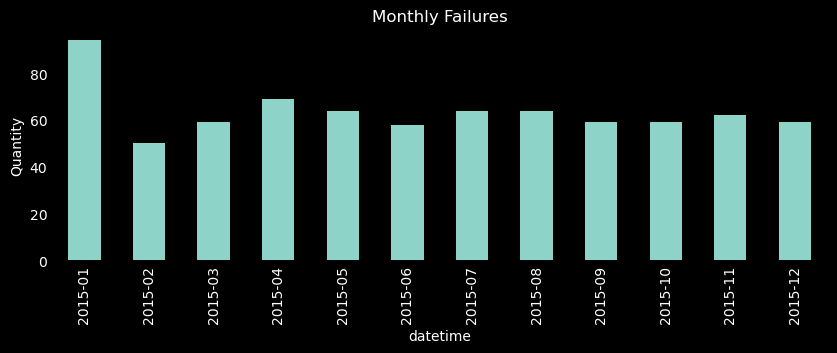

In [49]:
failures_per_month = failures.groupby(failures.datetime.dt.to_period("M")).size()
failures_per_month.plot(kind="bar", figsize=(10,3), title="Monthly Failures")
plt.ylabel("Quantity")
plt.show()

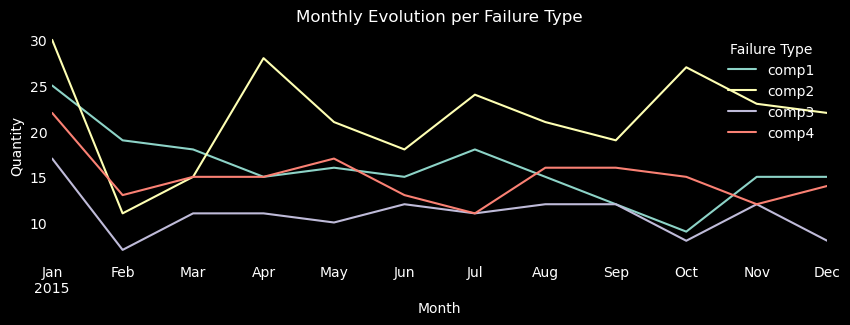

In [50]:
failures_per_type_month = (
    failures.groupby([failures.datetime.dt.to_period("M"), "failure"])
    .size()
    .unstack(fill_value=0)
)

failures_per_type_month.plot(figsize=(10,3))
plt.title("Monthly Evolution per Failure Type")
plt.ylabel("Quantity")
plt.xlabel("Month")
plt.legend(title="Failure Type")
plt.show()


At this stage, no clear pattern is observed.  
The volume of failures appears stable over time, with no evident trends or seasonality.

#### Domain Reference  
To gain better context and make more precise observations, we will cross-reference failure data with the machine inventory. This will allow us to start identifying behavioral patterns, such as which models exhibit a higher number of failures.  

When analyzing failures, it is important not to focus solely on absolute counts, but also on **failure rates**. Rates provide a clearer measure of product reliability or defectiveness, beyond simply whether a model is more represented in the inventory.


* First, the failure distribution by model

In [51]:
# Calculate failes count per machine ID
failures_per_machine = failures["machineID"].value_counts().reset_index()
failures_per_machine.columns = ["machineID", "failures"]

# Merge with inventory
failures_with_info = pd.merge(
    machines,
    failures_per_machine,
    on="machineID",
    how="left"
)

# Fill null values with 0
failures_with_info["failures"] = failures_with_info["failures"].fillna(0).astype(int)


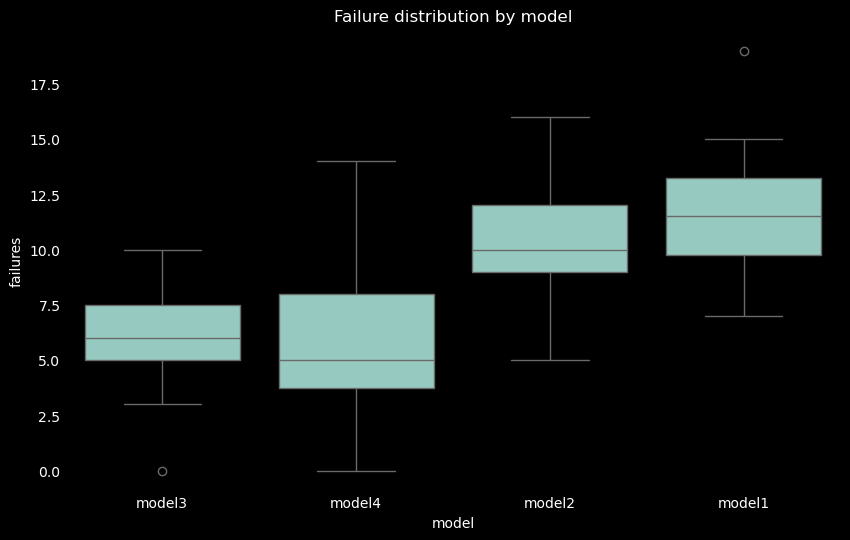

In [52]:
plt.figure(figsize=(10,6))
sns.boxplot(data=failures_with_info, x="model", y="failures")
plt.title("Failure distribution by model")
plt.show()

* Next, Failure rate by model and component

In [53]:
# Get failures by model and type
failures_by_model_type = failures.groupby(["machineID", "failure"]).size().reset_index(name="failures")
failures_by_model_type = pd.merge(failures_by_model_type, machines[["machineID","model"]], on="machineID", how="left")
failures_model_type = failures_by_model_type.groupby(["model", "failure"])["failures"].sum().reset_index()

# Count machines by model
machines_by_model = machines["model"].value_counts().reset_index()
machines_by_model.columns = ["model", "machine_count"]

# Merge and calculate rate
failures_rate_type = pd.merge(failures_model_type, machines_by_model, on="model")
failures_rate_type["failure_rate"] = failures_rate_type["failures"] / failures_rate_type["machine_count"]

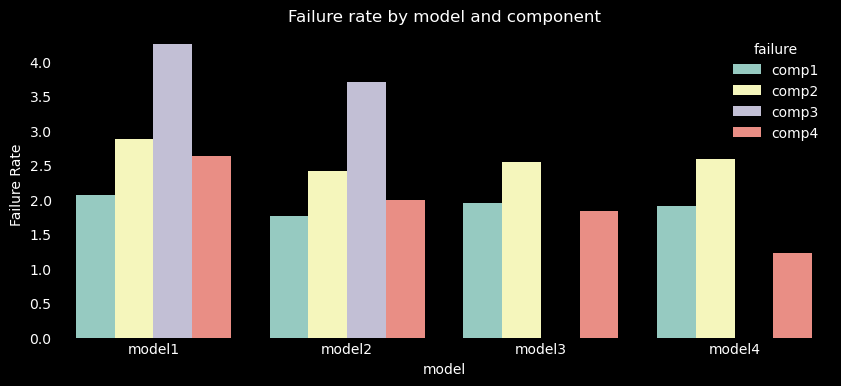

In [54]:
plt.figure(figsize=(10,4))
sns.barplot(data=failures_rate_type, x="model", y="failure_rate", hue="failure")
plt.title("Failure rate by model and component")
plt.ylabel("Failure Rate")
plt.show()

* It could be clearer in a heatmap

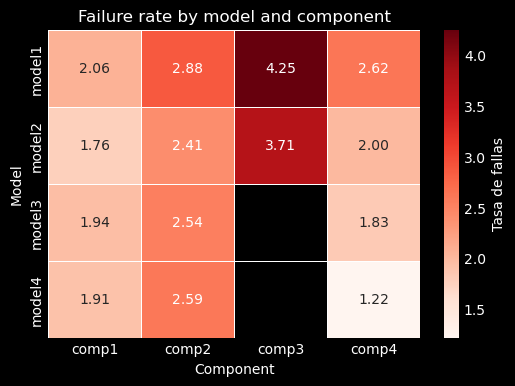

In [55]:
heatmap_data = failures_rate_type.pivot(index="model", columns="failure", values="failure_rate")

plt.figure(figsize=(6,4))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".2f", cmap="Reds", linewidths=0.5, cbar_kws={'label': 'Tasa de fallas'}
)
plt.title("Failure rate by model and component")
plt.ylabel("Model")
plt.xlabel("Component")
plt.show()

**Preliminary Insight (Failure Rate by Model and Component):**  
When normalizing failures by the number of machines, the most critical scenario corresponds to **Model1 with failures in Component 3**, which shows the highest failure rate in the dataset.  
This indicates that, regardless of the number of machines available, this model–component pair represents the greatest vulnerability.  
Overall, **Component 3** exhibits a higher propensity to fail, particularly in Model1 and Model2, while Models 3 and 4 show lower and more evenly distributed failure rates.


* Finally, we need to check whether failures from different components can occur simultaneously in the same machine and timestamp.

In [56]:
check = failures.groupby(["datetime", "machineID"]).size()
print((check > 1).sum())

42


#### **Preliminary EDA Summary (Failures):**  
- The dataset contains **761 records** with 3 variables (`datetime`, `machineID`, `failure`).  
- No missing values or duplicates were detected.  
- Failures represent less than **0.1% of all telemetry records**, confirming a highly imbalanced distribution — as expected in real-world failure prediction problems.  
- Failure events are linked to specific machines and components, but overall volume appears stable over time with no clear seasonal pattern. 
- In some cases, multiple components fail simultaneously on the same machine and timestamp, which should be considered when defining the target variable and labeling strategy.
- The main analytical value will come from merging this file with telemetry, maintenance, and machine inventory to derive meaningful failure rates and predictive features.


### Errors File

#### Author's description

* Error (PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

#### Quick Overview
* First a quick overview, dataframe shape, nulls, update frequency, etc.

In [57]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [58]:
errors.shape

(3919, 3)

In [59]:
errors.dtypes

datetime     datetime64[ns]
machineID             int64
errorID              object
dtype: object

In [60]:
errors.isnull().sum()

datetime     0
machineID    0
errorID      0
dtype: int64

#### Distributions

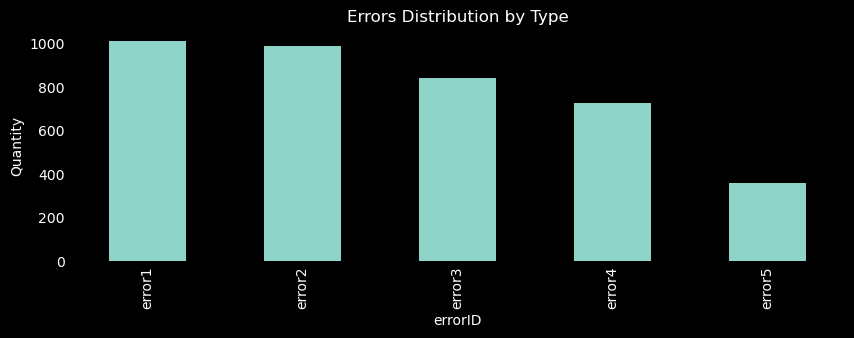

In [61]:
errors["errorID"].value_counts().plot(kind="bar", figsize=(10,3))
plt.title("Errors Distribution by Type")
plt.ylabel("Quantity")
plt.show()

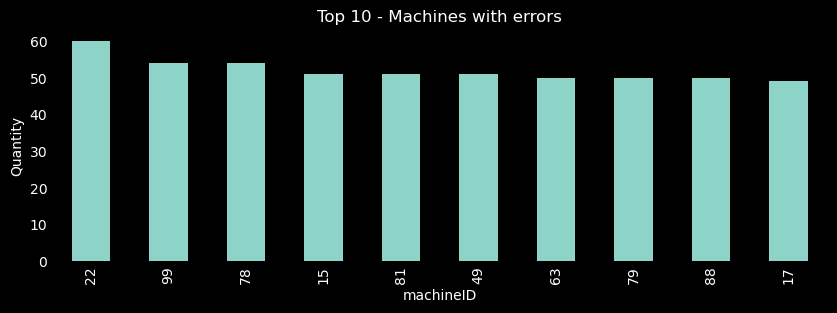

In [62]:
errors["machineID"].value_counts().head(10).plot(kind="bar", figsize=(10,3))
plt.title("Top 10 - Machines with errors")
plt.ylabel("Quantity")
plt.show()


#### Evolution over time

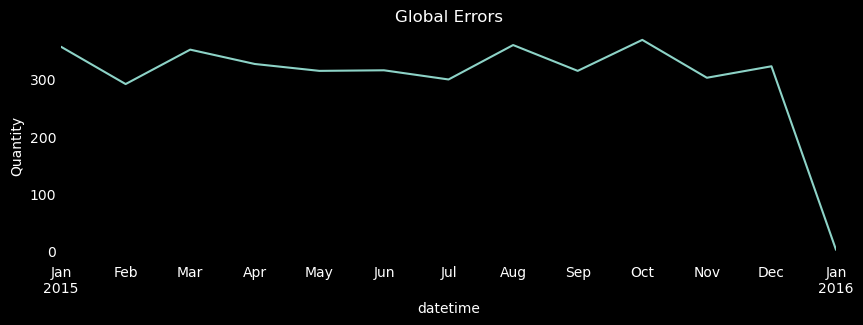

In [63]:
errors.groupby(errors.datetime.dt.to_period("M")).size().plot(kind="line", figsize=(10,3))
plt.title("Global Errors")
plt.ylabel("Quantity")
plt.show()

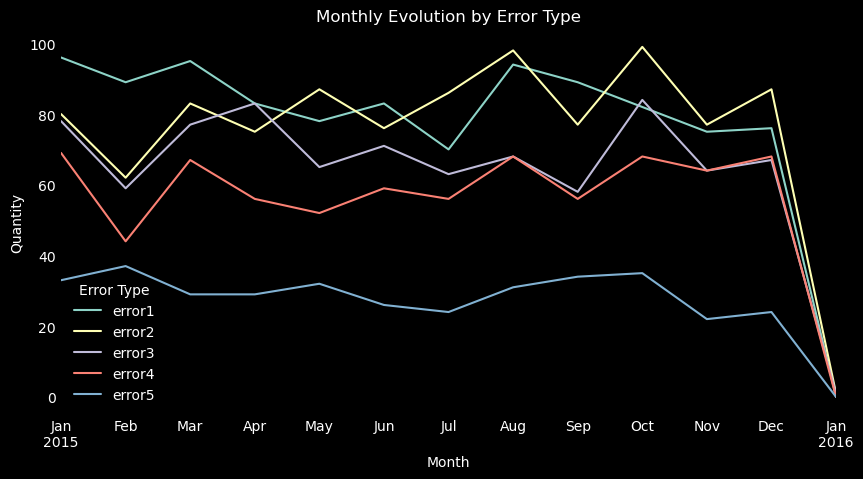

In [64]:
# Group Errors by type
errors_monthly = (
    errors.groupby([errors.datetime.dt.to_period("M"), "errorID"])
    .size()
    .reset_index(name="count")
)
errors_pivot = errors_monthly.pivot(index="datetime", columns="errorID", values="count").fillna(0)

# Plot
errors_pivot.plot(figsize=(10,5))
plt.title("Monthly Evolution by Error Type")
plt.ylabel("Quantity")
plt.xlabel("Month")
plt.legend(title="Error Type")
plt.show()


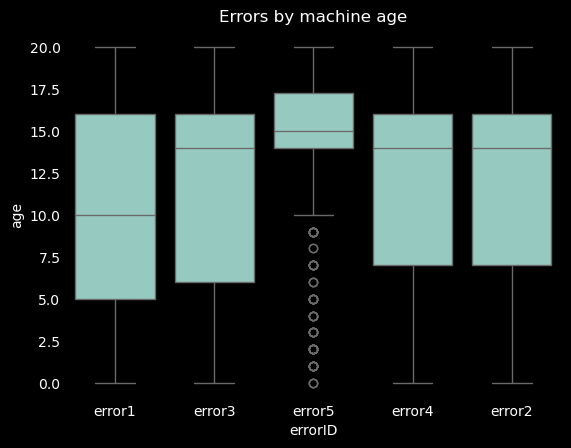

In [65]:
errors_with_age = pd.merge(errors, machines, on="machineID", how="left")
sns.boxplot(data=errors_with_age, x="errorID", y="age")
plt.title("Errors by machine age")
plt.show()

#### Domain Reference

As with the failures case, it could be important to check error rates and its evolution

In [66]:
# Get model quantity
inv_model = machines.groupby("model")["machineID"].nunique()

# Get machine information
errors_mt = (errors
             .merge(machines[["machineID","model"]], on="machineID", how="left")
             .groupby(["model","errorID"]).size())

# Calculate Error rate
rate_mt = (errors_mt / inv_model).rename("error_rate").reset_index()


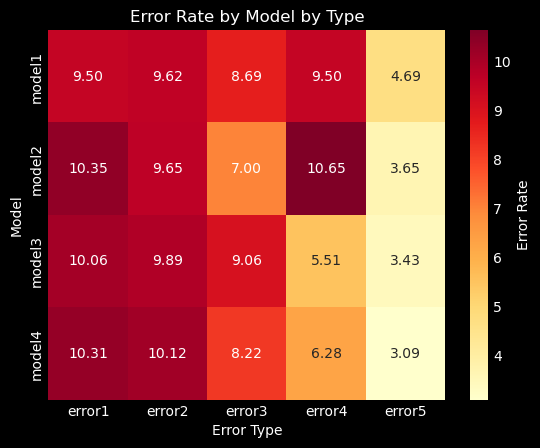

In [67]:
hm = rate_mt.pivot(index="model", columns="errorID", values="error_rate")
sns.heatmap(hm, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={"label":"Error Rate"})
plt.title("Error Rate by Model by Type"); plt.ylabel("Model"); plt.xlabel("Error Type"); plt.show()


In [68]:
# Caclulate Error Rate by Age (binned) 

# Create bins and count machines in each bin
machines["age_bin"] = pd.cut(machines["age"], bins=[0,5,10,15,20], right=True)
inv_age = machines.groupby("age_bin", observed=True)["machineID"].nunique()

# Count errors by age bin
errors_age = (errors.merge(machines[["machineID","age_bin"]], on="machineID", how="left")
                    .groupby("age_bin", observed=True).size())

# Calculate error rate by age bin
rate_age = (errors_age / inv_age).fillna(0).rename("error_rate").reset_index()
print(rate_age)

    age_bin  error_rate
0    (0, 5]       39.45
1   (5, 10]       36.27
2  (10, 15]       42.46
3  (15, 20]       39.00


#### **Preliminary Note on Error Analysis**  

The `errors` file contains **3,919 records** of warning-type notifications that occurred during 2015 across the 100 machines.  
Unlike maintenance and failures, errors are consistently present over time, with no abrupt changes suggesting modifications in logging policy.  

- The **most frequent errors** are `error1` and `error2` (~1,000 records each), while `error5` is the least common (~350 records).  
- All machines report errors, although with varying intensity: the top 10 machines account for more than 50 errors each.  
- Regarding **machine age**, errors occur at all stages, but machines aged 10–15 years show higher rates, and `error5` tends to appear more often in older equipment.  
- By **model**, error rates are fairly similar (9–11 errors per machine on average), though some specific patterns are observed:  
  - `model2` reports more `error4` events.  
  - `model3` and `model4` show fewer occurrences of `error5`.  

📌 **Preliminary Decision:**  
Errors will be considered as a **leading indicator** in the predictive modeling. Their early occurrence and relatively higher frequency compared to failures may provide valuable signals of component degradation before critical failures take place.


---

## **Global EDA Summary**  

Each file contributes a different dimension to the predictive maintenance problem:  
- `telemetry`: real-time operating conditions.  
- `maintenance`: intervention history.  
- `failures`: critical events (main target).  
- `errors`: early warnings (leading indicators).  
- `machines`: baseline information for each asset.  
  

📌 **Preliminary Decision:** The next step will be to merge these datasets to build an enriched dataset that combines operating conditions, warnings, historical interventions, and machine context in order to model failure probability.
